In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord #, Angle
from gammapy.modeling import Fit, Parameter, Parameters#, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)


import yaml
import sys
import json

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
from gammapy.estimators import FluxPointsEstimator
from my_estimator_points_sed_19 import My_FluxPointsEstimator
from my_estimator_points_core_19 import My_FluxPoints
#definitons

In [2]:
'''import argparse
CLI=argparse.ArgumentParser()
CLI.add_argument( "--rnd" )  
CLI.add_argument( "--amplitude" )  
CLI.add_argument( "--false_est" )   
args = CLI.parse_args()
input_ = dict()
input_['rnd'] = int(args.rnd)
input_['amplitude'] = float(args.amplitude)
input_['false_est'] = bool(args.false_est)'''

input_ = dict()
input_['rnd'] = int(0)
input_['amplitude'] = float(1e-9)
input_['false_est'] = bool(False)


rnd = input_['rnd']
amplitude =input_['amplitude']* u.Unit('cm-2 s-1 TeV-1')
false_est = input_['false_est']

print("...." * 20)
print("...." * 20)
print("...." * 20)
print("RND.................", input_['rnd'])
print("amplitude...........", amplitude)
print("false_est...........", false_est)

print("...." * 20)
print("...." * 20)
print("...." * 20)

................................................................................
................................................................................
................................................................................
RND................. 0
amplitude........... 1e-09 1 / (cm2 s TeV)
false_est........... False
................................................................................
................................................................................
................................................................................


In [3]:
pos_frozen = True
spatial_model_type = "pointsource_center"
outputfolder = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Fluxpoints/output/data_asimov_tests'
inputfolder_robustness = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Robustness'


if spatial_model_type == "pointsource_center":
    outputfile ='/Ooutput'+str(amplitude.value)+'.json'
    
with open(outputfolder+outputfile, 'r') as f:
    data = json.load(f)
j = 0
rnds = list(data.keys()) 

print("setting to started ..")
print("fitting rnd dataset number:", rnd)
data[str(rnd)]['started'] = True

with open(outputfolder+outputfile, 'w') as fp:
    json.dump(data, fp, indent=4)

setting to started ..
fitting rnd dataset number: 0


In [4]:
def plot_nui_distribution(nui_values_co, sys, mus, stds):
    ii = i_end - i_start
    ii = ii // 3 + 1
    fig, axs = plt.subplots(ii,3, figsize =(10,ii* 3) )
    for i,e in enumerate(xaxis[i_start:i_end]):
        ax = axs.flatten()[i]
        mu, sigma_ = mus[i+i_start], stds[i+i_start]  # mean and standard deviation
        s = nui_values_co[i*amount_free_par : (i+1)* amount_free_par]
        count, bins, ignored = ax.hist(s, 20, density=False, alpha = 0.3, color = 'red',)
        #ax.set_xlim(-10,10)
        ax.set_title(f'Energy: {xaxis[i+i_start].value:.2} TeV')
        ax.plot(bins,   max(count) *
                                np.exp( - (bins - mu)**2 / (2 * sigma_**2) ),
                          linewidth=2, color='r')
        ylim = ax.get_ylim()
        
        ax.vlines(0 +sys[i+i_start] *100, ylim[0], ylim[1],color = 'red' )
        ax.vlines(0 -sys[i+i_start] *100 , ylim[0], ylim[1],color = 'red')
    plt.tight_layout()
        
def plot_corr_matrix(dataset):
    M = np.linalg.inv(dataset.inv_corr_matrix)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(M)  # interpolation='nearest')
    fig.colorbar(cax);
    print("Maximal expected sys amplitude in % of bg:", np.sqrt( M.max() ) * 100)

def plot_residual(dataset, max_ = None):
    res_standard = (
        dataset.residuals("diff/sqrt(model)")
        #.slice_by_idx(dict(energy=slice(6, 9)))
        .smooth(0.1 * u.deg)
        )
    if max_ is None:
        vmax = np.nanmax(np.abs(res_standard.data))
    else:
        vmax = max_
    res_standard.slice_by_idx(dict(energy=slice(i_start,i_end))).plot_grid(add_cbar=1, 
                                                                  vmax=vmax, vmin=-vmax, cmap="coolwarm")
    return res_standard            

def compute_K_matrix(l_deg, sigma, ndim_spatial_nui, ndim_spectral_nui,geom_down ):
    helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
    helper_map2 = helper_map.copy()
    ndim_spatial_nui_1D = int(np.sqrt(ndim_spatial_nui))
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sigma[e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

In [5]:
with open(inputfolder_robustness+'/0_estimate_sys_per_ebin.yml', "r") as ymlfile:
    sys_read = yaml.load(ymlfile, Loader=yaml.FullLoader)
mus = sys_read['mus']
stds = sys_read['stds']

path_local_repo =      '/home/saturn/caph/mppi045h/Nuisance_Asimov_Datasets'
path_local_repo_flux = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Fluxpoints'

In [6]:
def read_mock_dataset(ad ):
    added = "_" + str(ad)
    dataset_N_sys = MapDatasetNuisance.read(f'{path_local_repo}/nui_dataset{added}.fits')
    with open(f'{path_local_repo}/nui_par{added}.yml', "r") as ymlfile:
        nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
    dataset_N_sys.N_parameters = Parameters.from_dict(nui_par )
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N_sys.name)
    models = Models([])
    models.append(bkg_model)
    dataset_N_sys.models =models
    return dataset_N_sys

dataset_N_sys_ex = read_mock_dataset(0)
emask = dataset_N_sys_ex.nuisance_mask.data.sum(axis=2).sum(axis=1) >0
xaxis = dataset_N_sys_ex.geoms['geom'].axes[0].center
i_start = 6
i_end = i_start + sum(emask)

downsampling_factor = 10
ndim_spatial_nui = dataset_N_sys_ex.geoms['geom_down'].data_shape[1] **2
print("# of Nuis per ebin:", ndim_spatial_nui)
l_corr, ndim_spectral_nui = 0.08,  i_end -i_start 
print("# of Ebins with Nuis:", ndim_spectral_nui)
bg = dataset_N_sys_ex.background
bg_e = bg.data.sum(axis=2).sum(axis=1)
amount_free_par = ndim_spatial_nui

models = Models.read(inputfolder_robustness+"/1a-Source_models.yaml")
model_asimov = models[spatial_model_type]
model_asimov.parameters['amplitude'].value = amplitude.value
print(model_asimov)

# of Nuis per ebin: 225
# of Ebins with Nuis: 14
SkyModel

  Name                      : pointsource_center
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.400   +/-    0.00             
    amplitude               :   1.00e-09   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :     83.600   +/-    0.00 deg         
    lat_0                   :     22.000   +/-    0.00 deg         




[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.00280429
 0.00450086 0.11561052 0.01815315 0.01218795 0.01240284 0.01148192
 0.0133735  0.01493884 0.         0.         0.         0.        ]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (150, 150, 24)
	ndim  : 3
	unit  : 
	dtype : float64

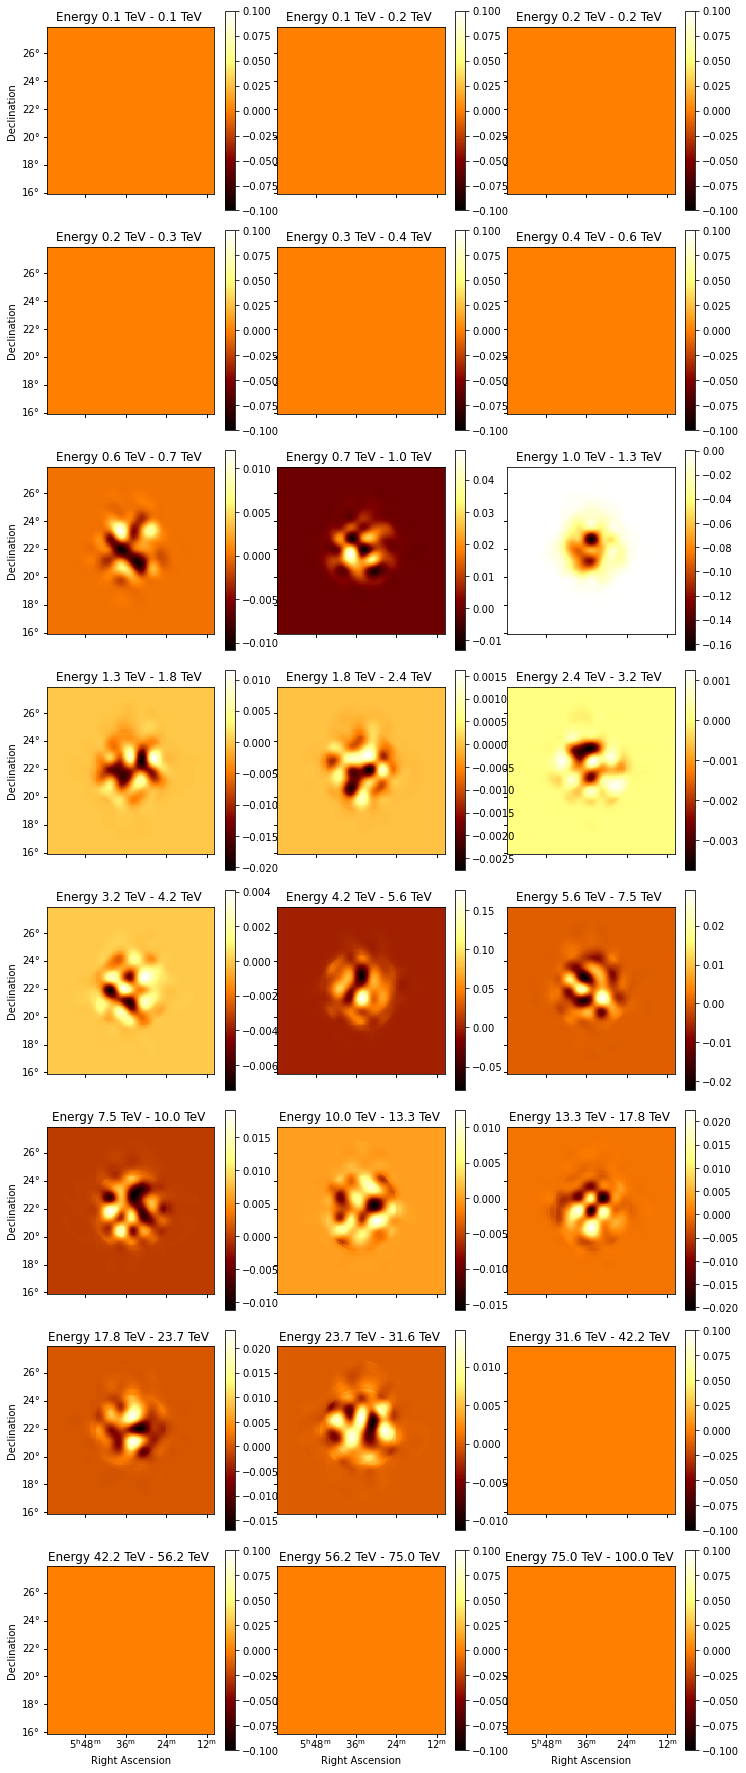

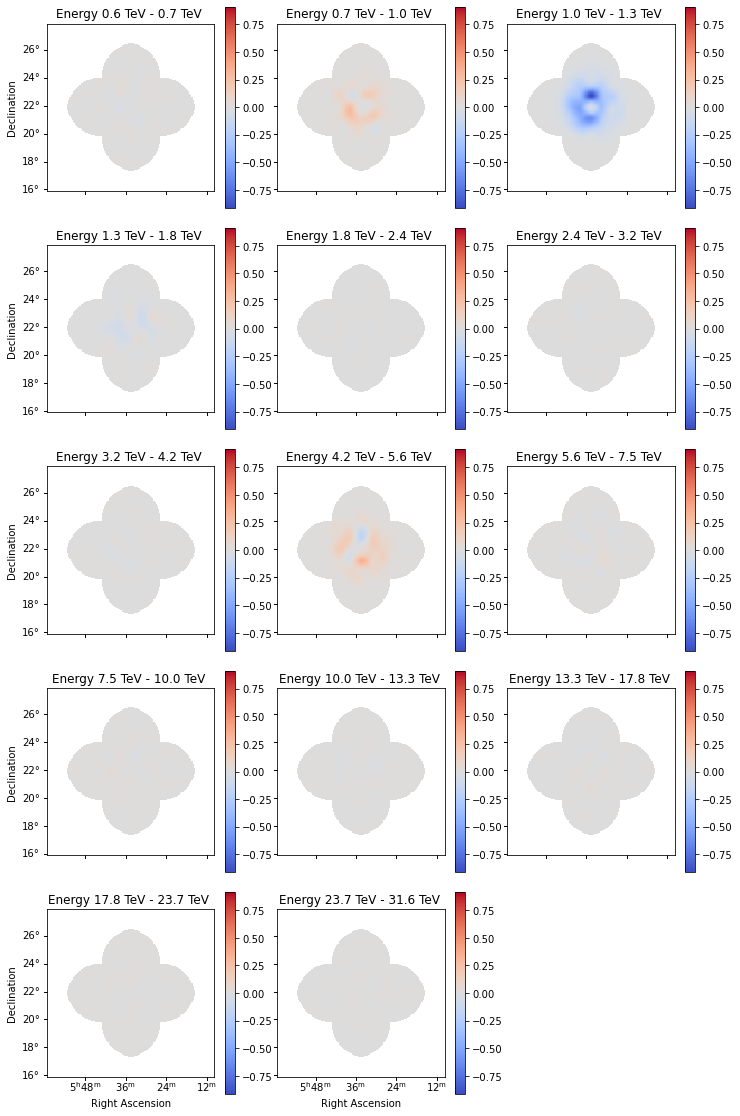

In [7]:
def create_dataset_fitting(dataset, mus, stds, falseningfactor):
    Nuisance_parameters_correct = Parameters([Parameter(name = par.name, value =0 ,frozen = par.frozen)  
      for  par in dataset.N_parameters])

    dataset_fitting = MapDatasetNuisance(
        background=dataset.background,
        exposure=dataset.exposure,
        psf=dataset.psf,
        edisp=dataset.edisp,
        mask_fit=dataset.mask_fit,
        mask_safe=dataset.mask_safe,
        inv_corr_matrix=dataset.inv_corr_matrix,
        N_parameters=Nuisance_parameters_correct,
        nuisance_mask=dataset.nuisance_mask,
    )

    bkg_model = FoVBackgroundModel(dataset_name=dataset_fitting.name)
    bkg_model.parameters["tilt"].frozen = False
    models = Models(model_asimov) 
    models.append(bkg_model)
    dataset_fitting.models = models
    
    if pos_frozen:
        dataset_fitting.models.parameters['lon_0'].frozen = True
        dataset_fitting.models.parameters['lat_0'].frozen = True
    
    ## Add systematic 
    sys_map = dataset.N_map().copy()
    for e in range(24):
        ex = dataset.exposure
        ex_ = ex.slice_by_idx(dict(energy_true= slice(e, e+1)))
        ex_.data = ex_.data / np.max(ex_.data)
        sys_map.slice_by_idx(dict(energy= slice(e, e+1))).data *= ex_.data
    sys_map.plot_grid(add_cbar = 1)
    dataset_fitting.counts = Map.from_geom(dataset_fitting.geoms['geom'])
    dataset_fitting.counts.data =  dataset.background.data * (1+sys_map.data) 
    
    ## Add Source
    dataset_fitting.counts.data += dataset_fitting.npred_signal()
    
    sys = (np.abs(mus) + falseningfactor* np.array(stds)) /100
    print(sys)
    correlation_matrix_co = compute_K_matrix(l_corr, np.array(sys[i_start:i_end]), 
                                             ndim_spatial_nui,
                                             ndim_spectral_nui, 
                                      dataset_N_sys_ex.geoms['geom_down'])
    dataset_fitting.inv_corr_matrix=np.linalg.inv(correlation_matrix_co)
    
    return dataset_fitting

dataset_N_sys = read_mock_dataset(rnd)
dataset_A_fitting = create_dataset_fitting (dataset_N_sys, mus, stds, 1)

plot_residual(dataset_A_fitting)

In [8]:
dataset_asimov_standard = MapDataset(
        background=dataset_A_fitting.background,
        exposure=dataset_A_fitting.exposure,
        psf=dataset_A_fitting.psf,
        edisp=dataset_A_fitting.edisp,
        mask_fit=dataset_A_fitting.mask_fit,
        mask_safe=dataset_A_fitting.mask_safe,
        counts = dataset_A_fitting.counts
)
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov_standard.name)
bkg_model.parameters["tilt"].frozen = False
models = Models(model_asimov.copy()) 
models.append(bkg_model)
dataset_asimov_standard.models = models

if pos_frozen:
    dataset_asimov_standard.models.parameters['lon_0'].frozen = True
    dataset_asimov_standard.models.parameters['lat_0'].frozen = True

    
fluxpoint_bins = dataset_asimov_standard.geoms['geom'].axes[0].edges[6::2].value


In [9]:
print("Fluxpoint Standard" )
fluxpointsestimator_standard = FluxPointsEstimator(
        energy_edges=fluxpoint_bins * u.TeV ,
        source=0,
        norm_min=0.8,
        norm_max=1.2,
        norm_n_values=11,
        norm_values=None,
        n_sigma=1,
        n_sigma_ul=2,
        reoptimize=True,
        selection_optional=["errn-errp", "ul","scan"],
    )

fluxpoints_standard = fluxpointsestimator_standard.run(dataset_asimov_standard)
fluxfilename = f"{path_local_repo_flux}/OOutput{amplitude.value}/Flux_{rnd}_{str(amplitude.value)}_st.fits"
fluxpoints_standard.write(fluxfilename,overwrite= True )



Fluxpoint Standard


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (1 / (cm2 s TeV))'>

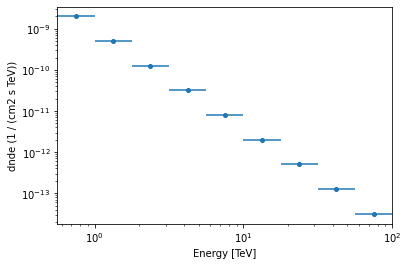

In [10]:
fluxpoints_standard.plot()

In [11]:
with open(outputfolder+outputfile, 'r') as f:
    data = json.load(f)

result= dict() 
result['standard'] = 'finished'

data[str(rnd)]['result'] = result
with open(outputfolder+outputfile, 'w') as fp:
    json.dump(data, fp, indent=4)

In [12]:
%%time
fluxpointsestimator_N = My_FluxPointsEstimator(
        energy_edges=fluxpoint_bins * u.TeV ,
        source=0,
        norm_min=0.8,
        norm_max=1.2,
        norm_n_values=11,
        norm_values=None,
        n_sigma=1,
        n_sigma_ul=2,
        reoptimize=True,
        selection_optional=["errn-errp","ul", ],
    )

dataset_A_fitting.N_parameters.freeze_all()
for i in [145,146,147]:
    dataset_A_fitting.N_parameters[i].frozen = False
fluxpoints_N = fluxpointsestimator_N.run([dataset_A_fitting])
    
fluxfilename = f"{path_local_repo_flux}/OOutput{amplitude.value}/Flux_{rnd}_{str(amplitude.value)}_N.fits"
fluxpoints_N.write(fluxfilename,overwrite= True )

E:  0.5623413251903491 TeV : 1.0 TeV
... computing estimate best fit
len parameters: 456
<ValueView par_000_norm=0.9998283457918772 par_001_norm=1.0159907832667951 par_002_tilt=-0.037218636463874036 par_003_db145=-9.691900855087181e-06 par_004_db146=2.9623043751073698e-06 par_005_db147=-8.51711273255208e-07>
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 128
	total stat : -4008498.10

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 128
	total stat : -4008498.10


len parameters: 456
<ValueView par_000_norm=3.399461321560071 par_001_tilt=-39.41991621472236 par_002_db145=-25.10704347162348 par_003_db146=2.9580375716275844 par_004_db147=43.90061155803197>
... computing errn-errp
len parameters: 456
<ValueView par_000_norm=9.998323191917693 par_001_norm=1.0160000178276136 par_002_tilt=-3.71898259573658

<ValueView par_000_norm=1.0000118014688995 par_001_norm=1.000933134488947 par_002_tilt=-0.00029790438300880787>
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 47
	total stat : -135644.06

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 47
	total stat : -135644.06


len parameters: 456
<ValueView par_000_norm=4.410307318755175 par_001_tilt=79.77904590827993>
... computing errn-errp
len parameters: 456
<ValueView par_000_norm=0.9999802719809293 par_001_norm=1.000930374769122 par_002_tilt=-2.9972707900116236>
norm_errp:  0.0081744535314211
norm_errn:  0.008127895900031157
... computing ul
len parameters: 456
<ValueView par_000_norm=9.999866961808008 par_001_norm=1.0009208431608518 par_002_tilt=-3.04289674310151>
ul:  {'norm': 1.0000118014688995, 'stat': -135644.05504938183, 'success': True, 'norm_err'

<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (1 / (cm2 s TeV))'>

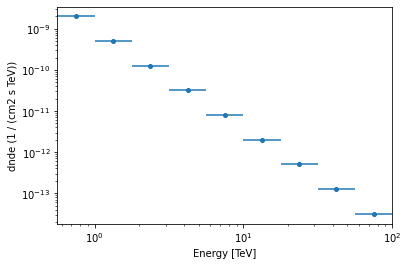

In [14]:
fluxpoints_N.plot()

In [15]:
with open(outputfolder+outputfile, 'r') as f:
    data = json.load(f)

result['N'] = 'finished'

data[str(rnd)]['result'] = result
with open(outputfolder+outputfile, 'w') as fp:
    json.dump(data, fp, indent=4)